<a href="https://colab.research.google.com/github/lualua0909/DeepLearning-LDS8/blob/main/Week_3/Chapter_6_RNN_%26_LSTM_Ex2_Singapore_tourist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Cho dữ liệu singapore_tourist.csv.
* Xây dựng model để dự đoán values cho thời gian tiếp theo
* Giải thích cách tính tham số từ summary của model

In [32]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
import math
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [33]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

In [34]:
# load the dataset
dataframe = pd.read_csv('https://raw.githubusercontent.com/lualua0909/DeepLearning-LDS8/main/Data/singapore_tourist.csv', usecols=[1], engine='python')
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   values  97 non-null     int64
dtypes: int64(1)
memory usage: 904.0 bytes


In [35]:
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset[:10]

array([[22.],
       [21.],
       [24.],
       [22.],
       [35.],
       [34.],
       [35.],
       [51.],
       [49.],
       [53.]], dtype=float32)

In [36]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [37]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [38]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [39]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [40]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) # somtimes: bigger output shape (e
model.add(Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


**Giải thích cách tính tham số**
* lstm_1 (LSTM) = [(num_units + input_dim + 1) x num_units] x 4 = [(4 + 1 + 1) x 4] x 4 = 96
* dense_1 = ((current layer n x previous layer n) + bias) = 1 x 4 + 1 = 5

In [41]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
62/62 [==============================] - 2s 3ms/step - loss: 0.2241
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1497
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1039
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0752
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0583
Epoch 6/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0494
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0450
Epoch 8/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0427
Epoch 9/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0408
Epoch 10/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0395
Epoch 11/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0386
Epoch 12/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0376
Epoch 13/100
62/62 [=================

In [42]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [43]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [44]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.63 RMSE
Test Score: 12.08 RMSE


In [45]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [46]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

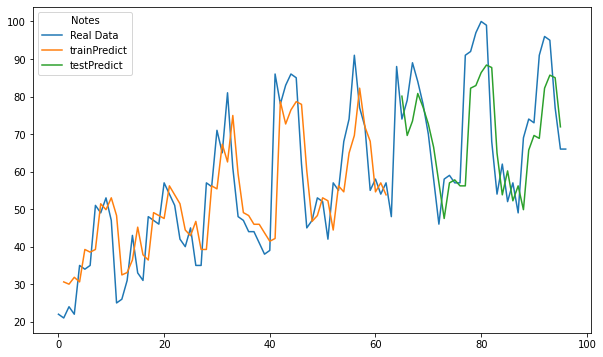

In [47]:
# plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(dataset), label='Real Data')
plt.plot(trainPredictPlot, label='trainPredict')
plt.plot(testPredictPlot, label='testPredict')
plt.legend(title="Notes")
plt.show()

In [48]:
ws = {}
for layer in model.layers:
  ws[layer.name] = layer.get_weights()
ws

{'dense_2': [array([[ 1.1713535 ],
         [-0.17152214],
         [-1.0101221 ],
         [-0.35710782]], dtype=float32), array([0.0796046], dtype=float32)],
 'lstm_2': [array([[ 1.1585295 , -0.7153108 ,  0.3135463 ,  0.3591114 ,  0.2586084 ,
           0.39366364, -0.23467714, -0.30566135,  0.3737473 ,  0.1566441 ,
          -1.0391674 , -0.06398113,  1.206854  ,  0.23613498,  1.1130955 ,
          -0.29022777]], dtype=float32),
  array([[-0.52328134,  0.19930929,  0.40253618,  0.05615793,  0.14631042,
           0.01383542,  0.27627534, -0.12195578, -0.3293625 , -0.12419195,
          -0.36977267,  0.03212616, -0.05403245,  0.08827101, -0.31695288,
          -0.18874943],
         [-0.15351681, -0.20057876, -0.07763547, -0.21882248, -0.13514604,
          -0.4996338 , -0.13870977, -0.3970373 , -0.24323283,  0.12663744,
          -0.14208364, -0.09820961, -0.34327075, -0.29859093,  0.06449317,
           0.34832466],
         [-0.3418566 ,  0.01497037, -0.0890625 , -0.03930859, -0.2

In [49]:
# x_new = 66 => next time = ?
x_new = scaler.transform([[66]])
x_new = numpy.reshape(x_new, (1, 1,1))
y_new = model.predict(x_new)
y_new = scaler.inverse_transform(y_new)
y_new

array([[63.361572]], dtype=float32)

**Với lượng dữ liệu ít, bài toán này họa động chưa được tốt**